In [37]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

**Build Data Loading Functions**

In [2]:
import gdown

In [3]:
'''url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')'''

"url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'\noutput='data.zip'\ngdown.download(url, output, quiet=False)\ngdown.extractall('data.zip')"

In [4]:
def load_video(path:str) -> List[float]:
    
    cap=cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
                      
    mean=tf.math.reduce_mean(frames)
    std =tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {num_to_char.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [7]:
def load_alignments(path: str) -> tf.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])

    # Convert characters to integers using tf.strings.to_number
    int_tokens = tf.strings.to_number(tf.strings.unicode_split(tokens, input_encoding='UTF-8'))[1:]

    # Pad or truncate to a consistent length (e.g., 40)
    int_tokens = tf.pad(int_tokens, [[0, 40 - tf.shape(int_tokens)[0]]])  # Option 1: Padding
    # int_tokens = int_tokens[:40]  # Option 2: Truncation

    # Stack individual tensors into a single 2D tensor
    alignments = tf.stack(int_tokens, axis=0)

    return alignments


In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0] #first splits after every \ and then the extension too (i.e '.')
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    ragged_alignments = load_alignments(alignment_path)    
    alignments = tf.RaggedTensor.to_tensor(ragged_alignments)
    #alignments= tf.reshape(alignments, [-1])
    #alignments = ragged_alignments.values.to_tensor()  # Convert to dense tensor
    alignments = tf.boolean_mask(alignments, tf.not_equal(alignments, 0))
    
    return frames, alignments

In [9]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [10]:
test_path = '.\\data\\s1\\bgwu7s.mpg'

In [11]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

#This code snippet extracts the bare filename (without path or extension) from a given file path,
#likely for further processing or use in operations that don't require the full path information.

'bgwu7s'

In [12]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]


'bgwu7s'

In [13]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [16]:
frames.shape

TensorShape([75, 46, 140, 1])

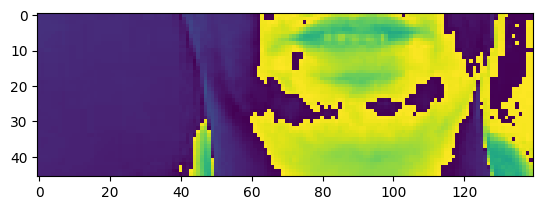

In [17]:
plt.imshow(frames[7])

In [18]:
alignments

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39, 21, 39,
       19,  5, 22,  5, 14, 39, 19, 15, 15, 14], dtype=int64)>

In [19]:
result = tf.strings.reduce_join(num_to_char(alignments))
print(result) 

tf.Tensor(b'bin green with u seven soon', shape=(), dtype=string)


In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

**Create Data Pipeline**

In [21]:
from matplotlib import pyplot as plt

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[50]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [23]:
len(test)

50

In [24]:
frames.shape

TensorShape([75, 46, 140, 1])

In [25]:
print(data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 50), dtype=tf.int64, name=None))>


In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
alignments.shape

(2, 50)

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val= sample.next()

In [30]:
val[1]

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  7, 39, 19,
         9, 24, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 2,  9, 14, 39,  2, 12, 21,  5, 39,  9, 14, 39,  6, 39, 26,  5,
        18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int64)

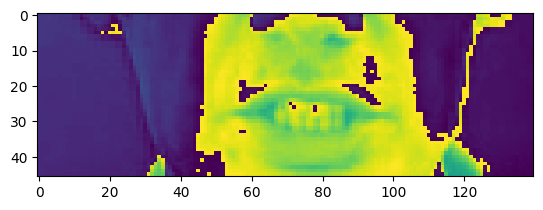

In [31]:
plt.imshow(val[0][0][35])


In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at g six please'>

**Design The Deep Neural Network**

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.initializers import Orthogonal

In [43]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [46]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='OrthogonalInitializer', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='OrthogonalInitializer', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [47]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)                   │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_15 (MaxPooling3D)      │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_16 (Conv3D)                   │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


In [49]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([37, 37, 37, 37, 37, 37, 37, 37, 16, 16, 16, 16, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 16, 16, 16,  9,  9], dtype=int64)>

In [50]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'8888pppppppppppppp!!!!!!!!iii!!!iii!ii!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!iiiii'>

In [51]:
model.input_shape

(None, 75, 46, 140, 1)

In [52]:
model.output_shape

(None, 75, 41)

**Setup Training Options and Train**

In [53]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [58]:
def CTCloss(y_true, y_pred): #connectionist temporal classification
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length*tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length*tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [59]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().deocde('utf-8'))
            print('~'*100)

In [61]:
from tensorflow.keras.optimizers import legacy

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCloss)


In [69]:
checkpoint_callback = ModelCheckpoint(os.path.join('models1','checkpoint.DATA-00000-OF-00001 File'), monitor='loss')

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=models1\checkpoint.DATA-00000-OF-00001 File

In [62]:
schedule_callback = LearningRateScheduler(scheduler)

In [63]:
example_callback = ProduceExample(test)

In [65]:
model.load_weights(os.path.join('models','checkpoint'))

ValueError: File format not supported: filepath=C:\Users\vinee\LipReading Project\models\checkpoint.data-00000-of-00001. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [65]:
model.fit(train, validation_data=test, epochs=4, initial_epoch=96, callbacks=[checkpoint_callback, schedule_callback, example_callback])